In [2]:
import pandas as pd
import numpy as np

import time
import matplotlib.pyplot as plt



In [4]:
#set path to REMOTES folder
path = '../../../data'

# Load the data
df = pd.read_csv(f'{path}/sensors_data.csv')


import ast

with open(f'{path}/exclude_IDs.txt') as f:
    lines = f.read()  # Read the entire content
    patients_to_remove = ast.literal_eval(lines)  # Safely evaluate the string as a list

df = df[~df['Patient ID'].isin(patients_to_remove)]



print(len(df))

#remove patient with ID R035
df = df[df['Patient ID'] != 'R035']

print(len(df))

#open the demo_data file 
demo_data = pd.read_csv(f'{path}/demo_data.csv')

#change the column title from study_id to Patient ID
demo_data = demo_data.rename(columns={'study_id': 'Patient ID'})


#merge the demo_data with the WS_data only keeping columns 'cpet_quality', cpet_bike, vo2peak_measured, anaerobic_threshold, bmi, age, gender
df = pd.merge(df, demo_data[['Patient ID', 'cpet_quality', 'cpet_bike', 'vo2peak_measured', 'anaerobicthreshold', 'bmi', 'gender', 'age']], on='Patient ID', how='left')


#if cpet_bike is 2, multiply vo2peak_measured by 0.9
df['vo2peak_measured'] = np.where(df['cpet_bike'] == 2, df['vo2peak_measured'] * 0.9, df['vo2peak_measured'])



164
163



Evaluating Model: With HRV
  Fold 1: Selected Alpha = 0.3277


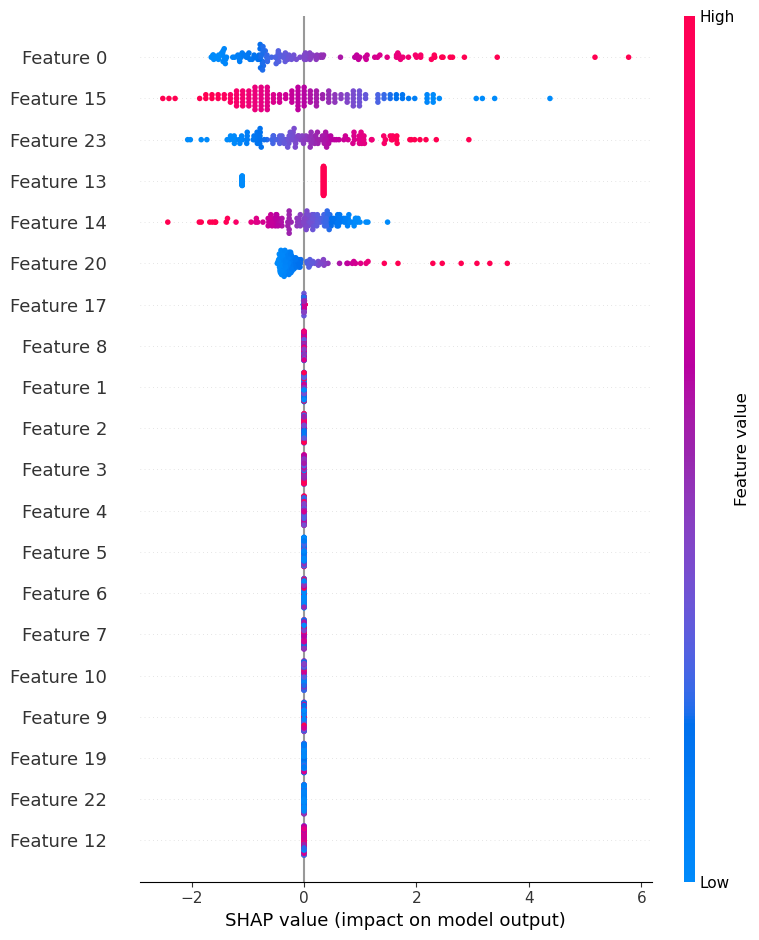

  Fold 2: Selected Alpha = 0.3111


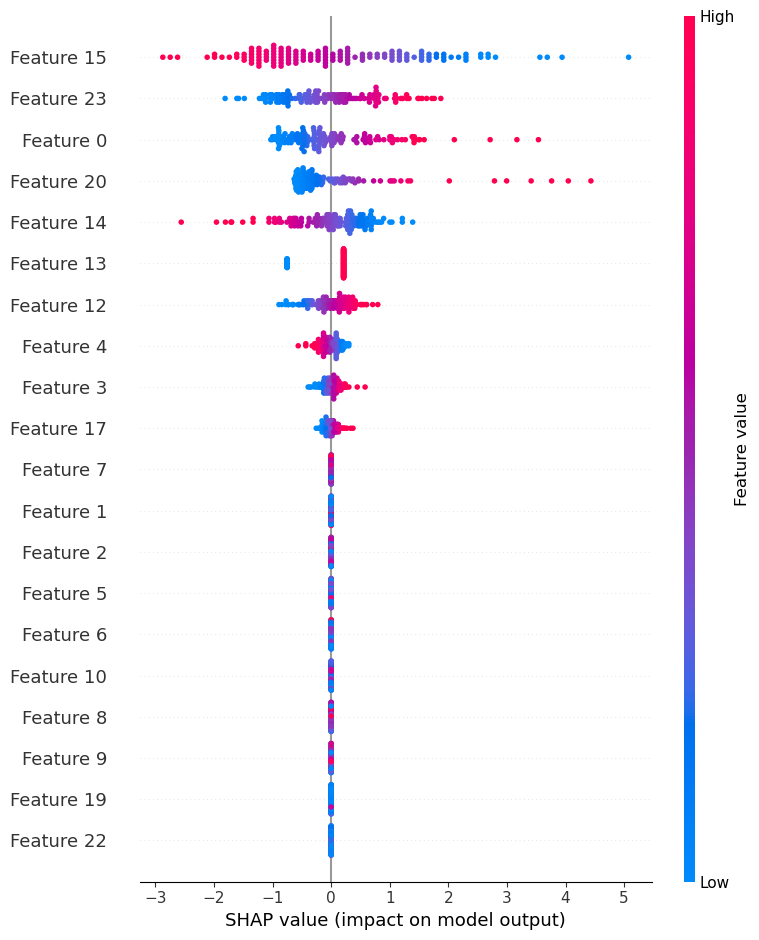

  Fold 3: Selected Alpha = 0.3259


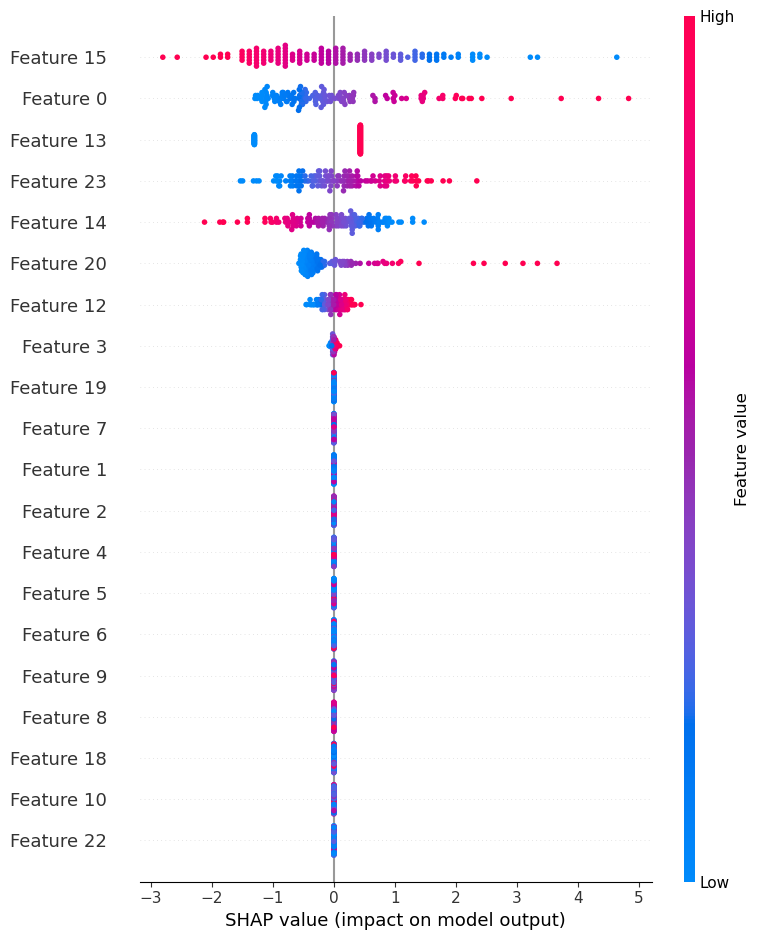

  Fold 4: Selected Alpha = 0.3408


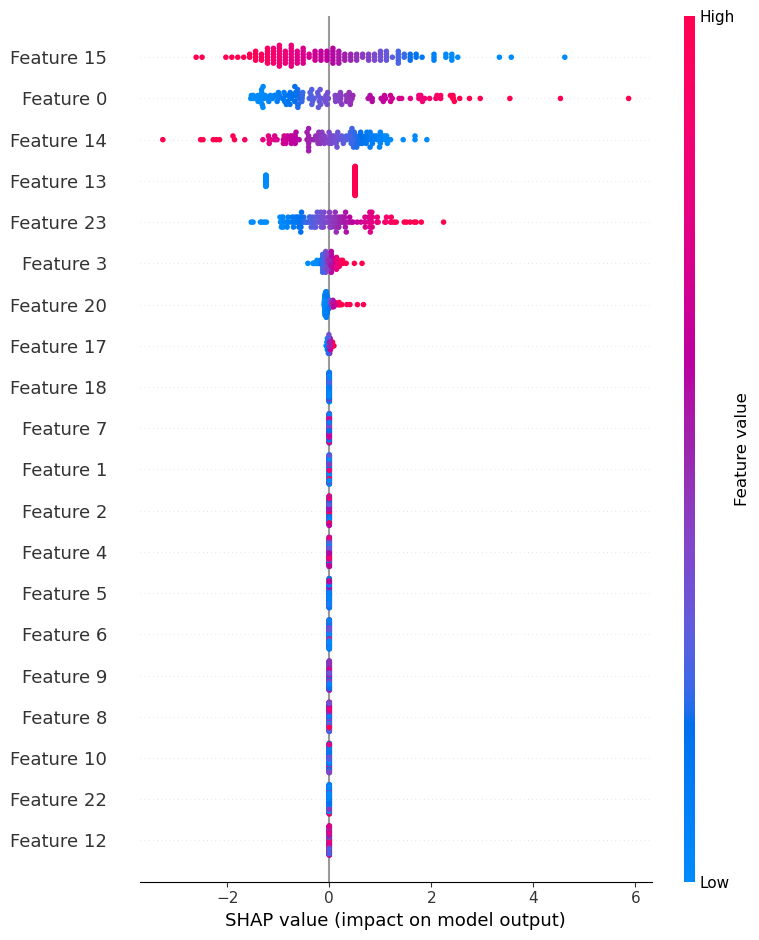

  Fold 5: Selected Alpha = 0.3024


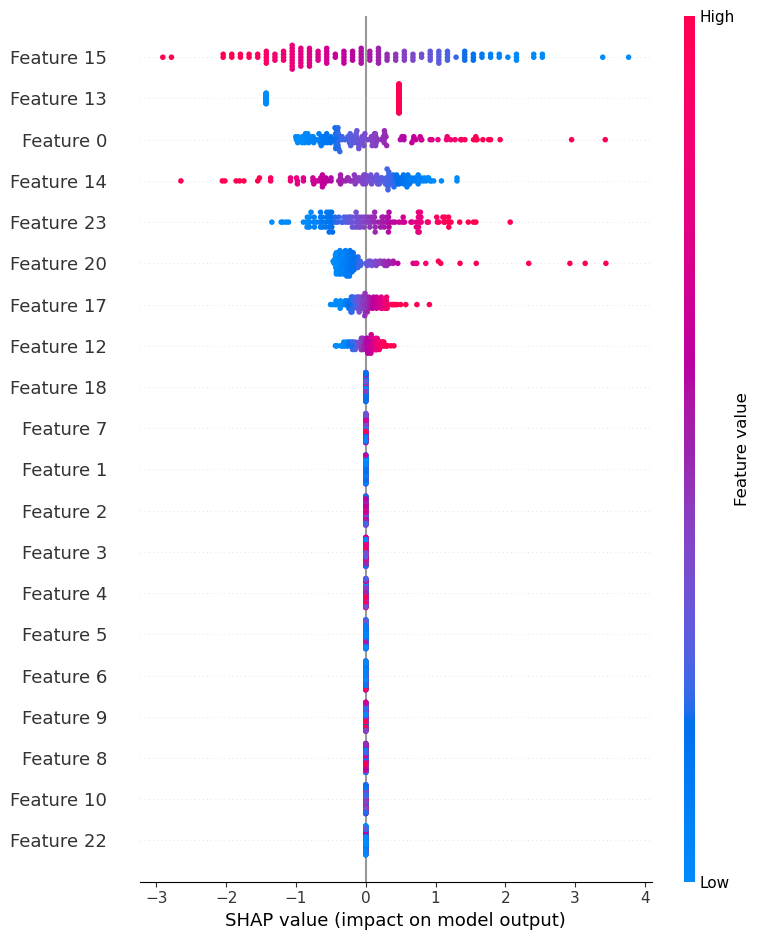


Evaluating Model: Without HRV
  Fold 1: Selected Alpha = 0.2312
  Fold 2: Selected Alpha = 0.2353
  Fold 3: Selected Alpha = 0.2299
  Fold 4: Selected Alpha = 0.2765
  Fold 5: Selected Alpha = 0.2134

Comparison of Models:

Model: With HRV
  Average Alpha: 0.3216
  Performance Metrics:
    Average Correlation: 0.6819
    Std Correlation: 0.0954
    Average R²: 0.4463
    Std R²: 0.1328
    Average SEE: 6.6615
    Std SEE: 0.4797
    Average MAE: 2.6011
    Std MAE: 0.1419
    Average RMSE: 3.4017
    Std RMSE: 0.2946
    Average APE: 15.1969
    Std APE: 1.5855

Model: Without HRV
  Average Alpha: 0.2373
  Performance Metrics:
    Average Correlation: 0.6651
    Std Correlation: 0.0994
    Average R²: 0.4260
    Std R²: 0.1408
    Average SEE: 4.9209
    Std SEE: 0.4415
    Average MAE: 2.6612
    Std MAE: 0.2074
    Average RMSE: 3.4702
    Std RMSE: 0.3251
    Average APE: 15.6745
    Std APE: 1.4854


In [8]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import shap
import numpy as np
import pandas as pd

# Define feature sets (without predefined alphas)
feature_sets = {
    "With HRV": {
        "features": ['steps', 'MVPA steps', 'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 
                     'Time in LPA', 'Time in SB', 'SB HR', 'Q1', 'Q2', 'Q3', 'Q95', 'gender', 
                     'bmi', 'age', 'SD2', 'MeanNN', 'VLF', 'LF', 'LF_HF', 'HF', 'pNN50', 'SDNNhr_1hr']
    },
    "Without HRV": {
        "features": ['steps', 'MVPA steps', 'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 
                     'Time in LPA', 'Time in SB', 'SB HR', 'Q1', 'Q2', 'Q3', 'Q95', 'gender', 
                     'bmi', 'age']
    }
}

# Initialize results dictionary
results = {}

# Loop through each feature set
for label, params in feature_sets.items():
    print(f"\nEvaluating Model: {label}")

    # Extract features
    features = params["features"]

    # Define X (predictors) and y (target)
    X = df[features]
    y = df['vo2peak_measured']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Set up 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store metrics and selected features per fold
    fold_alphas = []
    fold_correlations, fold_mae, fold_rmse, fold_rsq, fold_see, fold_ape = [], [], [], [], [], []

    # Perform cross-validation manually
    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### **🚀 Nested Cross-Validation for Alpha Selection** ###
        lasso_cv = LassoCV(cv=5, random_state=42)  # Inner 5-fold CV to tune alpha
        lasso_cv.fit(X_train, y_train)

        best_alpha = lasso_cv.alpha_  # Best alpha selected within this fold
        fold_alphas.append(best_alpha)
        print(f"  Fold {fold + 1}: Selected Alpha = {best_alpha:.4f}")

        ### **🚀 Train Final LASSO Model Using Best Alpha** ###
        lasso = Lasso(alpha=best_alpha)
        lasso.fit(X_train, y_train)

        ### **🚀 Evaluate Model** ###
        y_pred_fold = lasso.predict(X_test)

        # Calculate metrics for this fold
        correlation_fold, _ = pearsonr(y_test, y_pred_fold)
        mae_fold = mean_absolute_error(y_test, y_pred_fold)
        rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred_fold))
        rsq_fold = r2_score(y_test, y_pred_fold)

        # Calculate SEE (Standard Error of the Estimate)
        n = len(y_test)
        k = X_train.shape[1]  # Number of predictors
        see_fold = np.sqrt(np.sum((y_test - y_pred_fold) ** 2) / (n - k - 1)) if k > 0 else np.nan

        ape_fold = np.mean(np.abs((y_test - y_pred_fold) / y_test) * 100)

        # Store metrics
        fold_correlations.append(correlation_fold)
        fold_mae.append(mae_fold)
        fold_rmse.append(rmse_fold)
        fold_rsq.append(rsq_fold)
        fold_see.append(see_fold)
        fold_ape.append(ape_fold)

        ### **🚀 SHAP Values Calculation for Feature Importance (only for HRV model)** ###
        if label == "With HRV":
            # Create the SHAP Explainer object
            explainer = shap.Explainer(lasso, X_train)  # Using the trained LASSO model for explanation
            shap_values = explainer(X_train)

            # Visualize SHAP values for feature importance (summarize the SHAP values)
            shap.summary_plot(shap_values, X_train)

    # Calculate average metrics across all folds
    results[label] = {
        "Average Alpha": np.mean(fold_alphas),
        "Performance": {
            "Average Correlation": np.mean(fold_correlations),
            "Std Correlation": np.std(fold_correlations),
            "Average R²": np.mean(fold_rsq),
            "Std R²": np.std(fold_rsq),
            "Average SEE": np.mean(fold_see),
            "Std SEE": np.std(fold_see),
            "Average MAE": np.mean(fold_mae),
            "Std MAE": np.std(fold_mae),
            "Average RMSE": np.mean(fold_rmse),
            "Std RMSE": np.std(fold_rmse),
            "Average APE": np.mean(fold_ape),
            "Std APE": np.std(fold_ape),
        }
    }

# Print Results
print("\nComparison of Models:")
for label, metrics in results.items():
    print(f"\nModel: {label}")
    print(f"  Average Alpha: {metrics['Average Alpha']:.4f}")
    print("  Performance Metrics:")
    for metric_name, metric_value in metrics["Performance"].items():
        if metric_value is not None:
            print(f"    {metric_name}: {metric_value:.4f}")


In [6]:
feature_groups = {
    'Anthropometrics': ['age', 'gender', 'bmi'],
    'Physical Activity': ['steps', 'Q95', 'Time in SB', 'Time in MVPA'],
    'Long-Term HRV': ['SDNNhr_1hr'],
    'Short-Term HRV': ['LF_HF', 'MeanNN', 'VLF'],
    'HR': ['Max HR', 'Min HR']
}

# Group colors
group_colors = {
    'Anthropometrics': 'blue',
    'Physical Activity': 'green',
    'Long-Term HRV': 'orange',
    'Short-Term HRV': 'red',
    'HR': 'purple'
}

# Define formatted feature labels
formatted_labels = {
    'age': 'Age',
    'steps': 'Steps',
    'SDNNhr_1hr': r'SDANN$_{\mathrm{HR}24}$ - 1hr',
    'bmi': 'BMI',
    'gender': 'Gender',
    'LF_HF': r'LF/HF',
    'MeanNN': 'Mean-NN',
    'RMSSD': 'RMSSD',
    'VLF' : 'VLF',
    'HF' : 'HF',
    'LF': 'LF',
    'Max HR': 'Max HR',
    'Min HR': 'Min HR',
    'Q95': 'Q95',
    'Time in SB': 'Time in SB',
    'Time in LPA': 'Time in LPA',
    'Time in MVPA': 'Time in MVPA',
    'SB HR': 'SB HR',
    'Q1': 'Q1',
    'Q2': 'Q2',
    'Q3': 'Q3',
    'pNN50': 'pNN50',
    'SD2': 'SD2',
    'MVPA steps': 'MVPA steps',
    'Resting HR': 'Resting HR'

}

  Fold 1: Selected Alpha = 0.1778
  Fold 2: Selected Alpha = 0.1941
  Fold 3: Selected Alpha = 0.3493
  Fold 4: Selected Alpha = 0.2646
  Fold 5: Selected Alpha = 0.2865
[<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>]


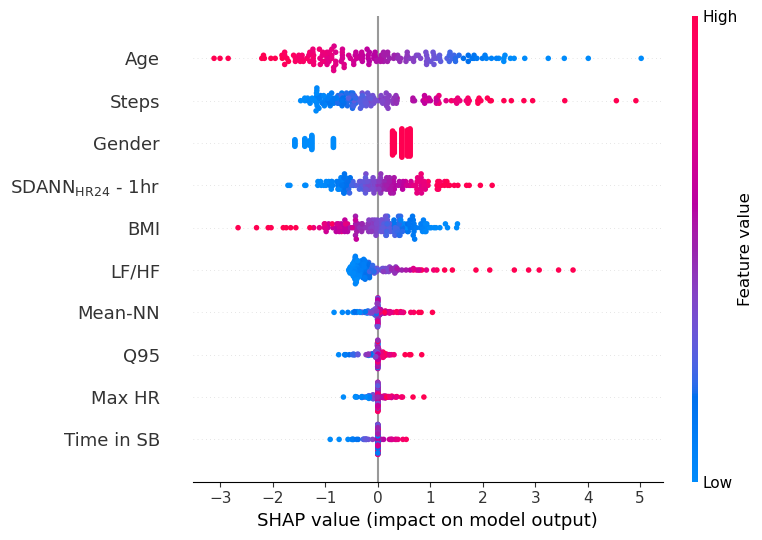

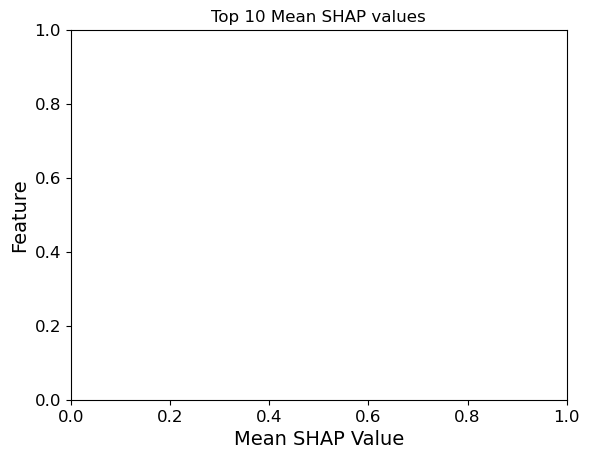

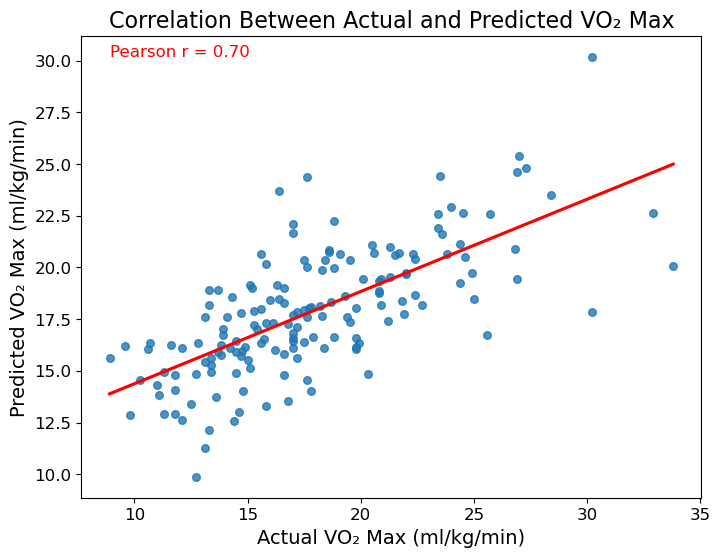

In [8]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature set for HRV model only
hrv_features = ['steps', 'MVPA steps', 'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 
                'Time in LPA', 'Time in SB', 'SB HR', 'Q1', 'Q2', 'Q3', 'Q95', 'gender', 
                'bmi', 'age', 'SD2', 'MeanNN', 'VLF', 'LF', 'LF_HF', 'HF', 'pNN50', 'SDNNhr_1hr']

# Initialize results dictionary
results = {}

# Initialize lists to store SHAP values and test data for all folds
all_shap_values = []
all_test_data = []

# Define X (predictors) and y (target) using only HRV features
X = df[hrv_features]
y = df['vo2peak_measured']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_alphas = []
fold_correlations, fold_mae, fold_rmse, fold_rsq, fold_see, fold_ape = [], [], [], [], [], []

all_actual_vo2 = []
all_predicted_vo2 = []

# Perform cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ### **🚀 Nested Cross-Validation for Alpha Selection** ###
    lasso_cv = LassoCV(cv=5, random_state=42)  # Inner 5-fold CV to tune alpha
    lasso_cv.fit(X_train, y_train)

    best_alpha = lasso_cv.alpha_  # Best alpha selected within this fold
    fold_alphas.append(best_alpha)
    print(f"  Fold {fold + 1}: Selected Alpha = {best_alpha:.4f}")

    ### **🚀 Train Final LASSO Model Using Best Alpha** ###
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train, y_train)

    ### **🚀 Evaluate Model** ###
    y_pred_fold = lasso.predict(X_test)
    # Store actual and predicted VO2 max values
    all_actual_vo2.extend(y_test)
    all_predicted_vo2.extend(y_pred_fold)

    # Calculate metrics for this fold
    correlation_fold, _ = pearsonr(y_test, y_pred_fold)
    mae_fold = mean_absolute_error(y_test, y_pred_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred_fold))
    rsq_fold = r2_score(y_test, y_pred_fold)

    # Calculate SEE (Standard Error of the Estimate)
    n = len(y_test)
    k = X_train.shape[1]  # Number of predictors
    see_fold = np.sqrt(np.sum((y_test - y_pred_fold) ** 2) / (n - k - 1)) if k > 0 else np.nan

    ape_fold = np.mean(np.abs((y_test - y_pred_fold) / y_test) * 100)

    # Store metrics
    fold_correlations.append(correlation_fold)
    fold_mae.append(mae_fold)
    fold_rmse.append(rmse_fold)
    fold_rsq.append(rsq_fold)
    fold_see.append(see_fold)
    fold_ape.append(ape_fold)

    ### **🚀 SHAP Values Calculation** ###
    explainer = shap.Explainer(lasso, X_train)  # Trained model on X_train
    shap_values = explainer(X_test)  # Compute SHAP values for the test set

    # Store SHAP values and corresponding test data
    all_shap_values.append(shap_values.values)  # Store SHAP values
    all_test_data.append(pd.DataFrame(X_test, columns=hrv_features))  # Convert X_test to DataFrame

# Debugging: Check the types before concatenation
print([type(obj) for obj in all_test_data])  # Should all be DataFrames

# Concatenate all SHAP values and test data across folds
final_shap_values = np.concatenate(all_shap_values, axis=0)
final_test_data = pd.concat(all_test_data, axis=0)

# Map the features to their formatted labels (if you have a dictionary for better names)
# Example: formatted_labels = {'age': 'Age', 'bmi': 'BMI', ...}  -> Modify this as needed
#updated_labels = [formatted_labels[feature] for feature in hrv_features]

# Find features that have at least one nonzero SHAP value
nonzero_feature_indices = np.where(np.abs(final_shap_values).sum(axis=0) > 0)[0]

# Filter SHAP values and test data to include only nonzero features
filtered_shap_values = final_shap_values[:, nonzero_feature_indices]
filtered_features = [hrv_features[i] for i in nonzero_feature_indices]

# Map features to formatted labels (if applicable)
updated_labels = [formatted_labels[f] for f in filtered_features]  # Only format used features

# Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(filtered_shap_values).mean(axis=0)

# Get indices of the top 10 features
top_n = 10
top_indices = np.argsort(mean_shap_values)[-top_n:]  # Get indices of top 10 features

# Filter SHAP values and feature names for only the top 10
top_shap_values = filtered_shap_values[:, top_indices]
top_features = [filtered_features[i] for i in top_indices]  # Get corresponding feature names
top_labels = [formatted_labels[f] for f in top_features]  # Map to formatted labels

# Create SHAP summary plot
plt.figure(figsize=(10, 6))  # Adjust figure size
shap.summary_plot(top_shap_values, final_test_data[top_features], feature_names=top_labels)

# Increase label sizes
plt.title("Top 10 Mean SHAP values")
plt.xlabel("Mean SHAP Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# Convert lists to a DataFrame for easier plotting
vo2_results = pd.DataFrame({'Actual VO2 Max': all_actual_vo2, 'Predicted VO2 Max': all_predicted_vo2})


# Plot correlation with regression line (No red background)
plt.figure(figsize=(8, 6))
sns.regplot(x=vo2_results['Actual VO2 Max'], 
            y=vo2_results['Predicted VO2 Max'], 
            scatter_kws={'s': 30},  # Adjust marker size
            line_kws={'color': 'red'}, 
            ci=None)  # Removes shaded confidence interval

# Add correlation coefficient
correlation, _ = pearsonr(vo2_results['Actual VO2 Max'], vo2_results['Predicted VO2 Max'])
plt.text(min(vo2_results['Actual VO2 Max']), 
         max(vo2_results['Predicted VO2 Max']), 
         f'Pearson r = 0.70', 
         fontsize=12, color='red')

# Labels and title with units
plt.xlabel("Actual VO₂ Max (ml/kg/min)", fontsize=14)
plt.ylabel("Predicted VO₂ Max (ml/kg/min)", fontsize=14)
plt.title("Correlation Between Actual and Predicted VO₂ Max", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

  Fold 1: Selected Alpha = 0.1778
Non-zero features (10): ['steps', 'Max HR', 'Min HR', 'Time in MVPA', 'gender', 'bmi', 'age', 'MeanNN', 'LF_HF', 'SDNNhr_1hr']
  Fold 2: Selected Alpha = 0.1941
Non-zero features (11): ['steps', 'Max HR', 'Time in SB', 'Q95', 'gender', 'bmi', 'age', 'MeanNN', 'VLF', 'LF_HF', 'SDNNhr_1hr']
  Fold 3: Selected Alpha = 0.3493
Non-zero features (7): ['steps', 'Q95', 'gender', 'bmi', 'age', 'LF_HF', 'SDNNhr_1hr']
  Fold 4: Selected Alpha = 0.2646
Non-zero features (9): ['steps', 'Q95', 'gender', 'bmi', 'age', 'MeanNN', 'VLF', 'LF_HF', 'SDNNhr_1hr']
  Fold 5: Selected Alpha = 0.2865
Non-zero features (9): ['steps', 'Max HR', 'Q95', 'gender', 'bmi', 'age', 'MeanNN', 'LF_HF', 'SDNNhr_1hr']
[<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>]
Existing feature names in shap_df: ['age' 'steps' 'gender' 'SDNNhr_1hr' 'bmi' 'L

/var/folders/m9/nskhz35n09b2_r2sw4dg_kxm0000gn/T/ipykernel_8132/1545949088.py:197: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(


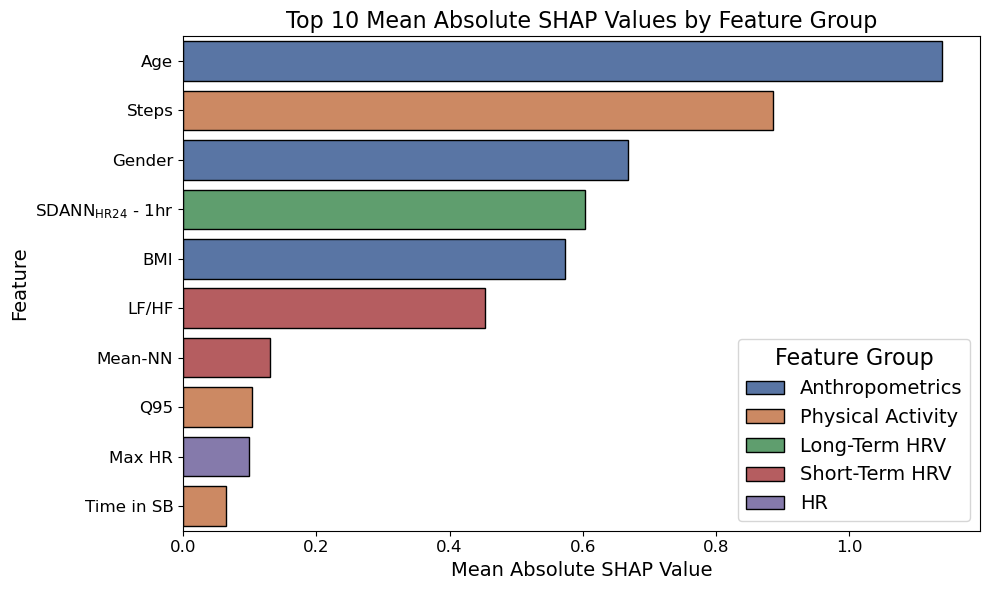

In [9]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_groups = {
    'Anthropometrics': ['age', 'gender', 'bmi'],
    'Physical Activity': ['steps', 'Q95', 'Time in SB', 'Time in MVPA'],
    'Long-Term HRV': ['SDNNhr_1hr'],
    'Short-Term HRV': ['LF_HF', 'MeanNN', 'VLF'],
    'HR': ['Max HR', 'Min HR']
}

# Group colors
group_colors = {
    'Anthropometrics': 'blue',
    'Physical Activity': 'green',
    'Long-Term HRV': 'orange',
    'Short-Term HRV': 'red',
    'HR': 'purple'
}

# Define formatted feature labels
formatted_labels = {
    'age': 'Age',
    'steps': 'Steps',
    'SDNNhr_1hr': r'SDANN$_{\mathrm{HR}24}$ - 1hr',
    'bmi': 'BMI',
    'gender': 'Gender',
    'LF_HF': r'LF/HF',
    'MeanNN': 'Mean-NN',
    'RMSSD': 'RMSSD',
    'VLF' : 'VLF',
    'HF' : 'HF',
    'LF': 'LF',
    'Max HR': 'Max HR',
    'Min HR': 'Min HR',
    'Q95': 'Q95',
    'Time in SB': 'Time in SB',
    'Time in LPA': 'Time in LPA',
    'Time in MVPA': 'Time in MVPA',
    'SB HR': 'SB HR',
    'Q1': 'Q1',
    'Q2': 'Q2',
    'Q3': 'Q3',
    'pNN50': 'pNN50',
    'SD2': 'SD2',
    'MVPA steps': 'MVPA steps',
    'Resting HR': 'Resting HR'

}


# Define feature set for HRV model only
hrv_features = ['steps', 'MVPA steps', 'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 
                'Time in LPA', 'Time in SB', 'SB HR', 'Q1', 'Q2', 'Q3', 'Q95', 'gender', 
                'bmi', 'age', 'SD2', 'MeanNN', 'VLF', 'LF', 'LF_HF', 'HF', 'pNN50', 'SDNNhr_1hr']

# Initialize results dictionary
results = {}

# Initialize lists to store SHAP values and test data for all folds
all_shap_values = []
all_test_data = []

# Define X (predictors) and y (target) using only HRV features
X = df[hrv_features]
y = df['vo2peak_measured']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_alphas = []
fold_correlations, fold_mae, fold_rmse, fold_rsq, fold_see, fold_ape = [], [], [], [], [], []

# Perform cross-validation manually
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ### **🚀 Nested Cross-Validation for Alpha Selection** ###
    lasso_cv = LassoCV(cv=5, random_state=42)  # Inner 5-fold CV to tune alpha
    lasso_cv.fit(X_train, y_train)

    best_alpha = lasso_cv.alpha_  # Best alpha selected within this fold
    fold_alphas.append(best_alpha)
    print(f"  Fold {fold + 1}: Selected Alpha = {best_alpha:.4f}")

    ### **🚀 Train Final LASSO Model Using Best Alpha** ###
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train, y_train)

    ### **🚀 Evaluate Model** ###
    y_pred_fold = lasso.predict(X_test)

    
        # Get indices of nonzero coefficients
    nonzero_indices = np.where(lasso.coef_ != 0)[0]

    # Get corresponding feature names
    nonzero_features = [hrv_features[i] for i in nonzero_indices]

    # Print the actual features
    print(f"Non-zero features ({len(nonzero_features)}): {nonzero_features}")


    # Calculate metrics for this fold
    correlation_fold, _ = pearsonr(y_test, y_pred_fold)
    mae_fold = mean_absolute_error(y_test, y_pred_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred_fold))
    rsq_fold = r2_score(y_test, y_pred_fold)

    # Calculate SEE (Standard Error of the Estimate)
    n = len(y_test)
    k = X_train.shape[1]  # Number of predictors
    see_fold = np.sqrt(np.sum((y_test - y_pred_fold) ** 2) / (n - k - 1)) if k > 0 else np.nan

    ape_fold = np.mean(np.abs((y_test - y_pred_fold) / y_test) * 100)

    # Store metrics
    fold_correlations.append(correlation_fold)
    fold_mae.append(mae_fold)
    fold_rmse.append(rmse_fold)
    fold_rsq.append(rsq_fold)
    fold_see.append(see_fold)
    fold_ape.append(ape_fold)

    ### **🚀 SHAP Values Calculation** ###
    explainer = shap.Explainer(lasso, X_train)  # Trained model on X_train
    shap_values = explainer(X_test)  # Compute SHAP values for the test set

    # Store SHAP values and corresponding test data
    all_shap_values.append(shap_values.values)  # Store SHAP values
    all_test_data.append(pd.DataFrame(X_test, columns=hrv_features))  # Convert X_test to DataFrame

# Debugging: Check the types before concatenation
print([type(obj) for obj in all_test_data])  # Should all be DataFrames

# Concatenate all SHAP values and test data across folds
final_shap_values = np.concatenate(all_shap_values, axis=0)
final_test_data = pd.concat(all_test_data, axis=0)

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(final_shap_values).mean(axis=0)
# Get indices of features that have nonzero SHAP values
nonzero_feature_indices = np.where(mean_shap_values > 0)[0]

# Filter SHAP values and feature names accordingly
filtered_shap_values = mean_shap_values[nonzero_feature_indices]
filtered_features = [hrv_features[i] for i in nonzero_feature_indices]

# Create a DataFrame only for features with nonzero SHAP values
shap_df = pd.DataFrame({
    'Feature': filtered_features,
    'Mean Absolute SHAP Value': filtered_shap_values
})

# Assign feature groups and colors
shap_df['Group'] = shap_df['Feature'].apply(
    lambda x: next((group for group, feat_list in feature_groups.items() if x in feat_list), 'Other')
)
shap_df['Color'] = shap_df['Group'].map(group_colors)

# Sort by SHAP value for better visualization
shap_df = shap_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Debugging: Check feature names in shap_df before applying mapping
print("Existing feature names in shap_df:", shap_df['Feature'].unique())

# Apply formatted labels safely
shap_df['Formatted Feature'] = shap_df['Feature'].apply(lambda x: formatted_labels.get(x, x))

# Debugging: Check if mapping was applied correctly
print("Formatted feature names in shap_df:", shap_df['Formatted Feature'].unique())

# Sort SHAP values in descending order and select the top 10 features
top_n = 10
shap_df = shap_df.nlargest(top_n, 'Mean Absolute SHAP Value')


# Use a colorblind-friendly palette
colorblind_palette = sns.color_palette("deep")

# Plot using Seaborn with improved accessibility
plt.figure(figsize=(10, 6))
sns.barplot(
    data=shap_df,
    x="Mean Absolute SHAP Value",
    y="Formatted Feature",  # Use formatted labels
    hue="Group",
    dodge=False,
    palette=colorblind_palette,  # Apply colorblind-friendly palette
    edgecolor="black"  # Add black edges to bars for contrast
)

# Add title, labels, and adjust font sizes
plt.title(f"Top {top_n} Mean Absolute SHAP Values by Feature Group", fontsize=16)
plt.xlabel("Mean Absolute SHAP Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust legend size
plt.legend(title="Feature Group", title_fontsize=16, fontsize=14, loc="best")

# Show the plot
plt.tight_layout()
plt.show()